In [1]:
from matplotlib import pyplot as plt
%matplotlib inline 
import PIL

In [2]:
#@title
!pip install -q ipywidgets
import ipywidgets as widgets
import sys
import os
import json

decoder_versions = [{
    "name": "Original",
    "dalle2_install_path": "git+https://github.com/Veldrovive/DALLE2-pytorch@f4b687798d367fc434d8127ab31141f0fea0db26",
    "decoder_path": "https://huggingface.co/Veldrovive/DA-VINC-E/resolve/main/text_conditioned_epoch_34.pth",
    "config_path": "https://huggingface.co/Veldrovive/DA-VINC-E/raw/main/text_conditioned_config.json"
},{
    "name": "New 1B (Aesthetic)",
    "dalle2_install_path": "dalle2_pytorch==0.15.4",
    "decoder_path": "https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/decoder/small_32gpus/latest.pth",
    "config_path": "https://huggingface.co/laion/DALLE2-PyTorch/raw/main/decoder/small_32gpus/decoder_config.json"
},{
    "name": "New 1.5B (Aesthetic)",
    "dalle2_install_path": "dalle2_pytorch==0.15.4",
    "decoder_path": "https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/decoder/1.5B/latest.pth",
    "config_path": "https://huggingface.co/laion/DALLE2-PyTorch/raw/main/decoder/1.5B/decoder_config.json"
},{
    "name": "New 1.5B (Laion2B)",
    "dalle2_install_path": "dalle2_pytorch==0.15.4",
    "decoder_path": "https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/decoder/1.5B_laion2B/latest.pth",
    "config_path": "https://huggingface.co/laion/DALLE2-PyTorch/raw/main/decoder/1.5B_laion2B/decoder_config.json"
}]

decoder_options = [version["name"] for version in decoder_versions]

def load_state():
    state_path = "script_state.json"
    try:
        assert os.path.exists(state_path)
        with open(state_path, "r") as f:
            state = json.load(f)
        # Make sure the save config is up to date. You might think this is a stupid system but...
        decoder = state["decoder"]
        if decoder is not None:
          current_decoder_name = decoder["name"]
          try:
              current_decoder_index = decoder_options.index(current_decoder_name)
              state["decoder"] = decoder_versions[current_decoder_index]
          except ValueError:
              print("The decoder you were using no longer exists. Please pick a new option.")
              state["decoder"] = None
        
        # Check if models are where they say they are
        for filekey in ["decoder", "decoder_config", "prior", "prior_config"]:
            path = state["model_paths"][filekey]
            if path is not None and not os.path.exists(path):
                print(f"{filekey} not found in expected place. Removing decoder config.")
                state["decoder"] = None
                state["model_paths"] = {
                    "decoder": None,
                    "decoder_config": None,
                    "prior": None,
                    "prior_config": None
                }
                save_state()
    except Exception as e:
        state = {
            "text_input": '',
            "text_repeat": 3,
            "prior_conditioning": 1.0,
            "img_repeat": 1,
            "decoder_conditioning": 3.5,
            "include_prompt_checkbox": True,
            "upsample_checkbox": True,
            "decoder": None,
            "model_paths": {
                "decoder": None,
                "decoder_config": None,
                "prior": None,
                "prior_config": None
            }
        }
    return state

current_state = load_state()

def save_state():
    global current_state
    state_path = "script_state.json"
    with open(state_path, "w") as f:
        json.dump(current_state, f)

def choice_equal(new_choice):
    global current_state
    if current_state["decoder"] is None:
        return False
    return current_state["decoder"]["decoder_path"] == new_choice["decoder_path"]

def dalle2_imported():
    return "dalle2_pytorch" in sys.modules

chosen_decoder = current_state["decoder"] if current_state["decoder"] is not None else decoder_versions[-1]

decoder_version_dropdown = widgets.Dropdown(
    options=decoder_options,
    value=chosen_decoder["name"],
    description='Decoder:',
    disabled=False,
)

start_setup_button = widgets.Button(
    description="Setup"
)

redownload_button = widgets.Button (
    description="Force Update Models"
)

main_layout = widgets.VBox([decoder_version_dropdown, start_setup_button, redownload_button])

def setup(decoder_version_name):
    global current_state
    global chosen_decoder
    new_choice = decoder_versions[decoder_options.index(decoder_version_name)]
    current_choice = current_state["decoder"]
    
    new_choice_equal = choice_equal(new_choice)
    already_imported = dalle2_imported()
    
    requires_restart = not new_choice_equal and already_imported  # The wrong dalle2_pytorch version is already imported
    requires_download = not new_choice_equal  # The wrong decoder version is downloaded
    
    print(f"You are using the model {new_choice['name']} which will be downloaded from {new_choice['decoder_path']}\n")
    if requires_restart:
        print("You environment already has dalle2 imported and collab requires a restart for you to be able to import the new version.")
        print("Restart your runtime to proceed.")
    elif requires_download:
        print("The models are not downloaded. They will be when you proceed.")
    else:
        print("You are ready to run inference. If you suspect your models are out of date, force update them.")
    
    chosen_decoder = new_choice
    

out = widgets.interactive_output(setup, { 'decoder_version_name': decoder_version_dropdown })
display(main_layout, out)

def download_models(current_choice):
    model_dir = "./models"
    os.makedirs(model_dir, exist_ok=True)
    
    # Download decoder
    print("Downloading decoder and decoder config")
    decoder_url = current_choice["decoder_path"]
    decoder_config_url = current_choice["config_path"]

    decoder_path = os.path.join(model_dir, "decoder.pth")
    decoder_config_path = os.path.join(model_dir, "decoder_config.json")
    
    !curl -L {decoder_url} > {decoder_path}
    !curl -L {decoder_config_url} > {decoder_config_path}
    
    # Download prior
    print("Downloading prior and prior config")
    prior_url = "https://huggingface.co/zenglishuci/conditioned-prior/resolve/main/vit-l-14/prior_aes_finetune.pth"
        
    prior_path = os.path.join(model_dir, "prior.pth")
    
    !curl -L {prior_url} > {prior_path}
    return decoder_path, decoder_config_path, prior_path, None

def install_dependencies(state):
    print("Installing dependencies")
    dalle2_install_path = state["decoder"]["dalle2_install_path"]
    print(f"Installing dalle2 version {dalle2_install_path}")
    !pip install -q {dalle2_install_path}
    
    !pip install -q matplotlib

    print("Do not worry if you get the error `fatal: destination path 'SwinIR' already exists and is not an empty directory.`")
    print("That just means SwinIR is already installed and I'm too lazy to do the check myself")
    !git clone https://github.com/JingyunLiang/SwinIR.git
    !pip install -q timm
    !pip install -q opencv-python

def start_setup(b):
    global current_state
    global chosen_decoder
    current_choice = current_state["decoder"]
    
    new_choice_equal = choice_equal(chosen_decoder)
    already_imported = dalle2_imported()
    
    requires_restart = not new_choice_equal and already_imported  # The wrong dalle2_pytorch version is already imported
    requires_download = not new_choice_equal  # The wrong decoder version is downloaded
    
    if requires_restart:
        raise Exception("Please restart your runtime before trying to set up the environment")
        
    if requires_download:
        try:
            decoder_path, decoder_config_path, prior_path, prior_config_path = download_models(chosen_decoder)
        except Exception as e:
            print("Model download was interrupted. Manually delete all models or environment may be corrupted.")
            current_state["decoder"] = None
            save_state()
            raise e
        current_state["decoder"] = chosen_decoder
        current_state["model_paths"] = {
                "decoder": decoder_path,
                "decoder_config": decoder_config_path,
                "prior": prior_path,
                "prior_config": prior_config_path
            }
        save_state()
    
    install_dependencies(current_state)

start_setup_button.on_click(start_setup)

def force_download(b):
    global current_state
    current_choice = current_state["decoder"]
    updated_choice = decoder_versions[decoder_options.index(current_choice["name"])]
    chosen_decoder = updated_choice
    try:
        decoder_path, decoder_config_path, prior_path, prior_config_path = download_models(chosen_decoder)
    except Exception as e:
        print("Model download was interrupted. Force update models or environment may be corrupted.")
        current_state["decoder"] = None
        save_state()
        raise e
    current_state["decoder"] = chosen_decoder
    current_state["model_paths"] = {
            "decoder": decoder_path,
            "decoder_config": decoder_config_path,
            "prior": prior_path,
            "prior_config": prior_config_path
        }
    save_state()
    install_dependencies(current_state)
    
redownload_button.on_click(force_download)

Output()

Installing dependencies
Installing dalle2 version git+https://github.com/Veldrovive/DALLE2-pytorch@f4b687798d367fc434d8127ab31141f0fea0db26
Do not worry if you get the error `fatal: destination path 'SwinIR' already exists and is not an empty directory.`
That just means SwinIR is already installed and I'm too lazy to do the check myself
fatal: destination path 'SwinIR' already exists and is not an empty directory.


In [3]:
#@title
# I would suggest running on a remote machine https://research.google.com/colaboratory/local-runtimes.html
import shutil
import torch
import os
import importlib


from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior, OpenAIClipAdapter, train_configs
from dalle2_pytorch.tokenizer import tokenizer

import numpy as np


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
#@title

def conditioned_on_text(config):
    try:
        return config.decoder.unets[0].cond_on_text_encodings
    except AttributeError:
        pass
    
    try:
        return config.decoder.condition_on_text_encodings
    except AttributeError:
        pass
    
    return False

decoder_text_conditioned = False
clip_config = None
def load_decoder(decoder_state_dict_path, config_file_path):
  config = train_configs.TrainDecoderConfig.from_json_path(config_file_path)
  global decoder_text_conditioned
  decoder_text_conditioned = conditioned_on_text(config)
  global clip_config
  clip_config = config.decoder.clip
  config.decoder.clip = None
  print("Decoder conditioned on text", decoder_text_conditioned)
  decoder = config.decoder.create().to(device)
  decoder_state_dict = torch.load(decoder_state_dict_path, map_location='cpu')
  decoder.load_state_dict(decoder_state_dict, strict=False)
  del decoder_state_dict
  decoder.eval()
  return decoder

In [5]:
def load_prior(model_path):
  prior_network = DiffusionPriorNetwork(
    dim=768,
    depth=24,
    dim_head=64,
    heads=32,
    normformer=True,
    attn_dropout=5e-2,
    ff_dropout=5e-2,
    num_time_embeds=1,
    num_image_embeds=1,
    num_text_embeds=1,
    num_timesteps=1000,
    ff_mult=4
  )

  diffusion_prior = DiffusionPrior(
    net=prior_network,
    clip=OpenAIClipAdapter("ViT-L/14"),
    image_embed_dim=768,
    timesteps=1000,
    cond_drop_prob=0.1,
    loss_type="l2",
    condition_on_text_encodings=True,
  ).to(device)

  state_dict = torch.load(model_path, map_location='cpu')
  if 'ema_model' in state_dict:
    print('Loading EMA Model')
    diffusion_prior.load_state_dict(state_dict['ema_model'], strict=True)
  else:
    print('Loading Standard Model')
    diffusion_prior.load_state_dict(state_dict['model'], strict=False)
  del state_dict
  return diffusion_prior


In [6]:
decoder = load_decoder(current_state["model_paths"]["decoder"], current_state["model_paths"]["decoder_config"])
diffusion_prior = load_prior(current_state["model_paths"]["prior"])

Decoder conditioned on text True
Loading EMA Model


In [21]:
#@title
clip = None
if clip_config is not None:
  clip = clip_config.create()

In [22]:
dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)

In [23]:
images = dalle2(
    ['a butterfly trying to escape a tornado'],
    cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

AssertionError: 

### Change conditioned on text to False

In [29]:
def conditioned_on_text(config):
    try:
        return config.decoder.unets[0].cond_on_text_encodings
    except AttributeError:
        pass
    
    try:
        return config.decoder.condition_on_text_encodings
    except AttributeError:
        pass
    
    return False

decoder_text_conditioned = False
clip_config = None
def load_decoder(decoder_state_dict_path, config_file_path):
  config = train_configs.TrainDecoderConfig.from_json_path(config_file_path)
  global decoder_text_conditioned
  decoder_text_conditioned = conditioned_on_text(config)
  print("Decoder conditioned on text", decoder_text_conditioned)
  global clip_config
  clip_config = config.decoder.clip
  config.decoder.clip = None
  print("Decoder conditioned on text", decoder_text_conditioned)
  decoder = config.decoder.create().to(device)
  decoder_state_dict = torch.load(decoder_state_dict_path, map_location='cpu')
  decoder.load_state_dict(decoder_state_dict, strict=False)
  del decoder_state_dict
  decoder.eval()
  return decoder

In [43]:
config = train_configs.TrainDecoderConfig.from_json_path(current_state["model_paths"]["decoder_config"])
decoder_state_dict_path = current_state["model_paths"]["decoder"]

In [44]:
config.decoder.condition_on_text_encodings = False
clip_config = config.decoder.clip
config.decoder.clip = None

In [45]:
decoder = config.decoder.create().to(device)
decoder_state_dict = torch.load(decoder_state_dict_path, map_location='cpu')
decoder.load_state_dict(decoder_state_dict, strict=False)
del decoder_state_dict
decoder.eval()

Decoder(
  (unets): ModuleList(
    (0): Unet(
      (init_conv): CrossEmbedLayer(
        (convs): ModuleList(
          (0): Conv2d(3, 208, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Conv2d(3, 104, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (2): Conv2d(3, 104, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
        )
      )
      (to_time_hiddens): Sequential(
        (0): SinusoidalPosEmb()
        (1): Linear(in_features=416, out_features=1664, bias=True)
        (2): GELU(approximate='none')
      )
      (to_time_tokens): Sequential(
        (0): Linear(in_features=1664, out_features=1024, bias=True)
        (1): Rearrange('b (r d) -> b r d', r=2)
      )
      (to_time_cond): Sequential(
        (0): Linear(in_features=1664, out_features=1664, bias=True)
      )
      (image_to_tokens): Sequential(
        (0): Linear(in_features=768, out_features=2048, bias=True)
        (1): Rearrange('b (n d) -> b n d', n=4)
      )
      (to_ima

In [46]:
images = dalle2(
    ['a butterfly trying to escape a tornado'],
    cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

AssertionError: 

In [49]:
config = train_configs.TrainDecoderConfig.from_json_path(current_state["model_paths"]["decoder_config"])
decoder_state_dict_path = current_state["model_paths"]["decoder"]

In [50]:
clip_config = config.decoder.clip
clip = None
if clip_config:
    clip = clip_config.create()

In [51]:
decoder = config.decoder.create().to(device)
decoder_state_dict = torch.load(decoder_state_dict_path, map_location='cpu')
decoder.load_state_dict(decoder_state_dict, strict=False)
del decoder_state_dict
decoder.eval()

Decoder(
  (clip): OpenAIClipAdapter(
    (clip): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): Sequential(
            (0): ResidualAttentionBlock(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
              )
              (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
                (gelu): QuickGELU()
                (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
              )
              (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            )
            (1): ResidualAttentionBlock(
              (attn)

In [52]:
images = dalle2(
    ['a butterfly trying to escape a tornado'],
    cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

AssertionError: 

### 加了conditioned 

In [62]:
config = train_configs.TrainDecoderConfig.from_json_path(current_state["model_paths"]["decoder_config"])
decoder_state_dict_path = current_state["model_paths"]["decoder"]

In [64]:
decoder_text_conditioned = conditioned_on_text(config)
print(decoder_text_conditioned)
decoder = config.decoder.create().to(device)
decoder_state_dict = torch.load(decoder_state_dict_path, map_location='cpu')
decoder.load_state_dict(decoder_state_dict, strict=False)
del decoder_state_dict
decoder.eval()

True


Decoder(
  (clip): OpenAIClipAdapter(
    (clip): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): Sequential(
            (0): ResidualAttentionBlock(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
              )
              (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
                (gelu): QuickGELU()
                (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
              )
              (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            )
            (1): ResidualAttentionBlock(
              (attn)

In [57]:
texts = ['a bat and a baseball fly through the air']

tokens = tokenizer.tokenize(texts).to(device)
print(tokens.shape)

image_embed = diffusion_prior.sample(tokens, cond_scale = 1)
print(image_embed.shape)

image_embed = image_embed.cpu().numpy()

embeddings = np.repeat(image_embed, 4, axis=0)
embeddings = torch.from_numpy(embeddings).float().to(device)

torch.Size([1, 256])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 768])


In [118]:
text = tokenizer.tokenize(texts).to(device)
text_cond = text if decoder.condition_on_text_encodings else None

images = decoder.sample(image_embed = embeddings, text = text_cond, cond_scale = 2)

images = images.cpu().permute(0, 2, 3, 1).numpy()

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

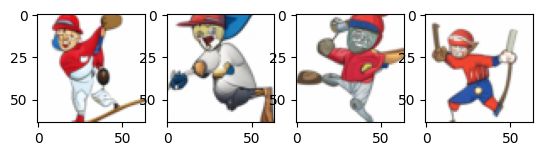

In [119]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4) 
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(images[0])
axarr[1].imshow(images[1])
axarr[2].imshow(images[2])
axarr[3].imshow(images[3])

### cond to False

In [7]:
config = train_configs.TrainDecoderConfig.from_json_path(current_state["model_paths"]["decoder_config"])
decoder_state_dict_path = current_state["model_paths"]["decoder"]

In [8]:
config.decoder.condition_on_text_encodings = False
clip_config = config.decoder.clip
config.decoder.clip = None

In [9]:
decoder_text_conditioned = conditioned_on_text(config)
print(decoder_text_conditioned)
decoder = config.decoder.create().to(device)
decoder_state_dict = torch.load(decoder_state_dict_path, map_location='cpu')
decoder.load_state_dict(decoder_state_dict, strict=False)
del decoder_state_dict
decoder.eval()

False


Decoder(
  (unets): ModuleList(
    (0): Unet(
      (init_conv): CrossEmbedLayer(
        (convs): ModuleList(
          (0): Conv2d(3, 208, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Conv2d(3, 104, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (2): Conv2d(3, 104, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
        )
      )
      (to_time_hiddens): Sequential(
        (0): SinusoidalPosEmb()
        (1): Linear(in_features=416, out_features=1664, bias=True)
        (2): GELU(approximate='none')
      )
      (to_time_tokens): Sequential(
        (0): Linear(in_features=1664, out_features=1024, bias=True)
        (1): Rearrange('b (r d) -> b r d', r=2)
      )
      (to_time_cond): Sequential(
        (0): Linear(in_features=1664, out_features=1664, bias=True)
      )
      (image_to_tokens): Sequential(
        (0): Linear(in_features=768, out_features=2048, bias=True)
        (1): Rearrange('b (n d) -> b n d', n=4)
      )
      (to_ima

In [10]:
texts = ['a bat and a baseball fly through the air']

tokens = tokenizer.tokenize(texts).to(device)
print(tokens.shape)

image_embed = diffusion_prior.sample(tokens, cond_scale = 1)
print(image_embed.shape)

image_embed = image_embed.cpu().numpy()

embeddings = np.repeat(image_embed, 4, axis=0)
embeddings = torch.from_numpy(embeddings).float().to(device)

torch.Size([1, 256])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 768])


In [11]:
decoder.condition_on_text_encodings

False

In [12]:
text = tokenizer.tokenize(texts).to(device)
text_cond = text if decoder.condition_on_text_encodings else None

In [14]:
text = tokenizer.tokenize(texts).to(device)
text_cond = text if decoder.condition_on_text_encodings else None

images = decoder.sample(image_embed = embeddings, text = text_cond, cond_scale = 2)

images = images.cpu().permute(0, 2, 3, 1).numpy()

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

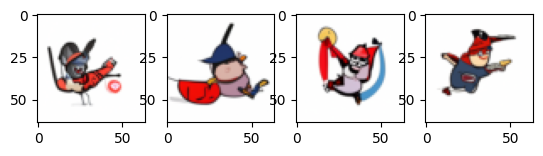

In [15]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4) 
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(images[0])
axarr[1].imshow(images[1])
axarr[2].imshow(images[2])
axarr[3].imshow(images[3])